# Metaspace annotation pipeline on Lithops

Experimental code to integrate the [METASPACE annotation engine](https://github.com/metaspace2020/metaspace/tree/master/metaspace/engine)
with [Lithops](https://github.com/lithops-cloud/lithops).

## Table of Contents
1. [Setup](#setup)
2. [Run Annotation Pipeline](#annotation)
3. [Display Annotations](#display)
4. [Clean Temp Data](#clean)

# <a name="setup"></a> Setup

Follow the instructions in [README.md](./README.md) to configure Lithops to use a cloud platform. If not configured, Lithops will execute code on the local computer using `multiprocessing`.

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%matplotlib inline

In [2]:
# We need this to overcome Python notebooks limitations of too many open files
import resource
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
print('Before:', soft, hard)

# Raising the soft limit. Hard limits can be raised only by sudo users
resource.setrlimit(resource.RLIMIT_NOFILE, (10000, hard))
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
print('After:', soft, hard)

Before: 4096 1048576
After: 10000 1048576


In [3]:
import logging
logging.basicConfig(level=logging.INFO)

## Project Setup

Check that the `Lithops-METASPACE` project is installed.

In [4]:
try:
    from annotation_pipeline import Pipeline
    import lithops
    print('Lithops version: ' + lithops.__version__)
except ImportError:
    print('Failed to import Lithops-METASPACE. Please run "pip install -e ." in this directory.')

Lithops version: 3.0.1


In [5]:
# Display Lithops version
import lithops
lithops.__version__

'3.0.1'

## Input Files Setup

Choose between the input config files to select how much processing will be done. See the `README.md` for more information on each dataset.

In [6]:
import json

# Input dataset and database (increase/decrease config number to increase/decrease job size)
input_ds = json.load(open('metabolomics/ds_config3.json'))
input_db = json.load(open('metabolomics/db_config3.json'))

In [7]:
input_ds

{'name': 'CT26_xenograft',
 'imzml_path': 'cos://embl-datasets/huge/ds.imzML',
 'ibd_path': 'cos://embl-datasets/huge/ds.ibd',
 'num_decoys': 20,
 'polarity': '+',
 'isocalc_sigma': 0.001238,
 'metaspace_id': '2016-09-21_16h06m49s'}

In [8]:
input_db

{'name': 'db_config3',
 'databases': ['metabolomics/db/mol_db1.csv',
  'metabolomics/db/mol_db2.csv',
  'metabolomics/db/mol_db3.csv',
  'metabolomics/db/mol_db4.csv'],
 'adducts': ['', '+H', '+Na', '+K'],
 'modifiers': ['', '-H2O', '-CO2', '-NH3']}

# <a name="annotation"></a> Run Annotation Pipeline

In [9]:
from annotation_pipeline.pipeline import Pipeline
pipeline = Pipeline(
    # Input dataset & metabolite database
    input_ds, input_db, 
    # Whether to use the pipeline False to accelerate repeated runs with the same database or dataset
    use_ds_cache=True, use_db_cache=True, 
    # Set to 'auto' to used the hybrid Serverless+VM implementation when available,
    # True to force Hybrid mode, or False to force pure Serverless mode.
    hybrid_impl='auto'
)

INFO:lithops.config:Lithops v3.0.1 - Python3.8
INFO:annotation-pipeline:Using the pure Serverless implementation
INFO:lithops.config:Lithops v3.0.1 - Python3.8
INFO:lithops.storage.backends.aws_s3.aws_s3:S3 client created - Region: us-east-1
INFO:lithops.serverless.backends.aws_lambda.aws_lambda:AWS Lambda client created - Region: us-east-1
INFO:lithops.storage.backends.aws_s3.aws_s3:S3 client created - Region: us-east-1
INFO:annotation-pipeline:Using cached logs/2023-10-11_12:14:42.csv for statistics


### Database preprocessing

In [10]:
# Upload required molecular databases from local machine
pipeline.upload_molecular_databases()

INFO:annotation-pipeline:Loaded 4 molecular databases from cache


In [11]:
# Parse the database
pipeline.build_database()

INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M000 - Selected Runtime: metaspace:01 - 512MB
INFO:lithops.invokers:Runtime metaspace:01 with 512MB is not yet deployed
INFO:lithops.serverless.backends.aws_lambda.aws_lambda:Deploying runtime: metaspace:01 - Memory: 512 Timeout: 180
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M000 - Starting function invocation: generate_formulas() - Total: 84 activations
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M000 - View execution logs at /tmp/lithops-pau/logs/97c380-0-M000.log
INFO:lithops.wait:ExecutorID 97c380-0 - Getting results from 84 function activations
/home/pau/.pyenv/versions/3.8.5/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:lithops.executors:ExecutorID 97c380-0 - Cleaning temporary data
INFO:lithops.invokers:ExecutorID 97c380-0 | Jo

In [12]:
# Calculate theoretical centroids for each formula
pipeline.calculate_centroids()

INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M004 - Selected Runtime: metaspace:01 - 2048MB
INFO:lithops.invokers:Runtime metaspace:01 with 2048MB is not yet deployed
INFO:lithops.serverless.backends.aws_lambda.aws_lambda:Deploying runtime: metaspace:01 - Memory: 2048 Timeout: 180
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M004 - Starting function invocation: calculate_peaks_chunk() - Total: 256 activations
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M004 - View execution logs at /tmp/lithops-pau/logs/97c380-0-M004.log
INFO:lithops.wait:ExecutorID 97c380-0 - Getting results from 256 function activations
INFO:lithops.executors:ExecutorID 97c380-0 - Cleaning temporary data
INFO:annotation-pipeline:Calculated 24448912 centroids in 256 chunks
INFO:annotation-pipeline:Calculated 256 centroid chunks


### Dataset preprocessing

In [13]:
# Upload the dataset if needed
pipeline.upload_dataset()

INFO:annotation-pipeline:Translating IBM COS path to public HTTPS path for example file "cos://embl-datasets/huge/ds.imzML"
INFO:annotation-pipeline:Uploading "https://s3.us-east.cloud-object-storage.appdomain.cloud/embl-datasets/huge/ds.imzML" to "aws_s3://lithops-pipelines/embl-datasets/huge/ds.imzML"
INFO:annotation-pipeline:Translating IBM COS path to public HTTPS path for example file "cos://embl-datasets/huge/ds.ibd"
INFO:annotation-pipeline:Uploading "https://s3.us-east.cloud-object-storage.appdomain.cloud/embl-datasets/huge/ds.ibd" to "aws_s3://lithops-pipelines/embl-datasets/huge/ds.ibd"


In [14]:
# Load the dataset's parser
pipeline.load_ds()

INFO:lithops.invokers:ExecutorID 97c380-0 | JobID A005 - Selected Runtime: metaspace:01 - 2048MB
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID A005 - Starting function invocation: get_portable_imzml_reader() - Total: 1 activations
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID A005 - View execution logs at /tmp/lithops-pau/logs/97c380-0-A005.log
INFO:lithops.wait:ExecutorID 97c380-0 - Getting results from 1 function activations
INFO:lithops.executors:ExecutorID 97c380-0 - Cleaning temporary data
INFO:annotation-pipeline:Parsed imzml: 50652 spectra found


In [15]:
# Parse dataset chunks into IBM COS
pipeline.split_ds()

INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M006 - Selected Runtime: metaspace:01 - 3072MB
INFO:lithops.invokers:Runtime metaspace:01 with 3072MB is not yet deployed
INFO:lithops.serverless.backends.aws_lambda.aws_lambda:Deploying runtime: metaspace:01 - Memory: 3072 Timeout: 180
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M006 - Starting function invocation: upload_chunk() - Total: 8 activations
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M006 - View execution logs at /tmp/lithops-pau/logs/97c380-0-M006.log
INFO:lithops.wait:ExecutorID 97c380-0 - Getting results from 8 function activations
INFO:lithops.executors:ExecutorID 97c380-0 - Cleaning temporary data
INFO:annotation-pipeline:Uploaded 8 dataset chunks


In [16]:
# Sort dataset chunks to ordered dataset segments
pipeline.segment_ds()

INFO:annotation-pipeline:Defining dataset segments bounds
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID A007 - Selected Runtime: metaspace:01 - 1024MB
INFO:lithops.invokers:Runtime metaspace:01 with 1024MB is not yet deployed
INFO:lithops.serverless.backends.aws_lambda.aws_lambda:Deploying runtime: metaspace:01 - Memory: 1024 Timeout: 180
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID A007 - Starting function invocation: get_segm_bounds() - Total: 1 activations
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID A007 - View execution logs at /tmp/lithops-pau/logs/97c380-0-A007.log
INFO:lithops.wait:ExecutorID 97c380-0 - Getting results from 1 function activations
INFO:lithops.executors:ExecutorID 97c380-0 - Cleaning temporary data
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M008 - Selected Runtime: metaspace:01 - 2560MB
INFO:lithops.invokers:Runtime metaspace:01 with 2560MB is not yet deployed
INFO:lithops.serverless.backends.aws_lambda.aws_lambda:Deploying runtime: metaspac

In [17]:
# Sort database chunks to ordered database segments
pipeline.segment_centroids()

INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M010 - Selected Runtime: metaspace:01 - 512MB
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M010 - Starting function invocation: clip_centr_df_chunk() - Total: 256 activations
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M010 - View execution logs at /tmp/lithops-pau/logs/97c380-0-M010.log
INFO:lithops.wait:ExecutorID 97c380-0 - Getting results from 256 function activations
INFO:lithops.executors:ExecutorID 97c380-0 - Cleaning temporary data
INFO:annotation-pipeline:Prepared 16123217 centroids
INFO:annotation-pipeline:Defining centroids segments bounds
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M011 - Selected Runtime: metaspace:01 - 512MB
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M011 - Starting function invocation: get_first_peak_mz() - Total: 256 activations
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M011 - View execution logs at /tmp/lithops-pau/logs/97c380-0-M011.log
INFO:lithops.wait:ExecutorID 97c38

### Engine

In [18]:
# Annotate the molecular database over the dataset by creating images into IBM COS
pipeline.annotate()

INFO:annotation-pipeline:Annotating...
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M014 - Selected Runtime: metaspace:01 - 2048MB
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M014 - Starting function invocation: process_centr_segment() - Total: 1612 activations
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M014 - View execution logs at /tmp/lithops-pau/logs/97c380-0-M014.log
INFO:lithops.wait:ExecutorID 97c380-0 - Getting results from 1612 function activations
INFO:lithops.executors:ExecutorID 97c380-0 - Cleaning temporary data
INFO:annotation-pipeline:Metrics calculated: 589889


In [19]:
# Discover expected false annotations by FDR (False-Discovery-Rate)
pipeline.run_fdr()

INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M015 - Selected Runtime: metaspace:01 - 1536MB
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M015 - Starting function invocation: build_ranking() - Total: 384 activations
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M015 - View execution logs at /tmp/lithops-pau/logs/97c380-0-M015.log
INFO:lithops.wait:ExecutorID 97c380-0 - Getting results from 384 function activations
INFO:lithops.executors:ExecutorID 97c380-0 - Cleaning temporary data
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M016 - Selected Runtime: metaspace:01 - 256MB
INFO:lithops.invokers:Runtime metaspace:01 with 256MB is not yet deployed
INFO:lithops.serverless.backends.aws_lambda.aws_lambda:Deploying runtime: metaspace:01 - Memory: 256 Timeout: 180
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M016 - Starting function invocation: merge_rankings() - Total: 64 activations
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M016 - View execution logs at /tmp/lit

### Lithops Summary

In [20]:
# Display statistics file
from annotation_pipeline.utils import PipelineStats
PipelineStats.get()

Total cost: 1.422 $ (Using IBM Cloud pricing)


,Function,Actions,Memory,AvgRuntime,Cost,CloudObjects
0,generate_formulas,84,512,16.121333,0.011511,2688
1,get_formulas_number_per_chunk,32,512,5.101886,0.001388,0
2,store_formulas_segments,32,512,6.834093,0.001859,256
3,store_formula_to_id_chunk,3,1536,6.446322,0.000493,3
4,calculate_peaks_chunk,256,2048,33.537673,0.291912,256
5,get_portable_imzml_reader,1,1024,8.190305,0.000139,1
6,upload_chunk,8,3072,21.496931,0.008771,8
7,get_segm_bounds,1,1024,21.340269,0.000363,0
8,segment_spectra_chunk,8,2560,15.672560,0.005329,56
9,merge_spectra_chunk_segments,7,2560,13.676499,0.004069,30


# <a name="display"></a> 3. Display Annotations

In [21]:
# Display most annotated molecules statistics
results_df = pipeline.get_results()
top_mols = (results_df
               .sort_values('msm', ascending=False)
               .drop('database_path', axis=1)
               .drop_duplicates(['mol','modifier','adduct']))
top_mols.head()

,fdr,mol,adduct,modifier,chaos,spatial,spectral,msm,total_iso_ints,min_iso_ints,max_iso_ints,full_mol
formula_i,,,,,,,,,,,,
2959862.0,0.0,C38H54O13,+Na,-CO2,0.999668,0.995433,0.980702,0.975900,"[2454054506.1633606, 839143503.8296051, 180984...","[0, 0, 0, 0]","[728481.8125, 277728.65625, 50540.99609375, 10...",C38H54O13-CO2+Na
453272.0,0.0,C27H51O12P,+H,,0.999696,0.977524,0.992644,0.970038,"[1432127318.97229, 401387524.8113098, 75165489...","[0, 0, 0, 0]","[285731.09375, 84245.640625, 16192.9931640625,...",C27H51O12P+H
5430867.0,0.0,C32H48O9,+Na,,0.999696,0.981686,0.977175,0.958987,"[1432127318.97229, 400566705.7662964, 75196994...","[0, 0, 0, 0]","[285731.09375, 84245.640625, 16192.9931640625,...",C32H48O9+Na
5430867.0,0.0,C33H48O11,+Na,-CO2,0.999696,0.981686,0.977175,0.958987,"[1432127318.97229, 400566705.7662964, 75196994...","[0, 0, 0, 0]","[285731.09375, 84245.640625, 16192.9931640625,...",C33H48O11-CO2+Na
5436873.0,0.0,C34H67N2O7P,+Na,,0.998471,0.978631,0.975690,0.953380,"[1847593.236114502, 597348.6312561035, 160565....","[0, 0, 0, 0]","[229986.953125, 87158.34375, 16609.775390625, ...",C34H67N2O7P+Na


In [22]:
# Download annotated molecules images
formula_images = pipeline.get_images(as_png=False)

INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M017 - Selected Runtime: metaspace:01 - 1024MB
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M017 - Starting function invocation: get_target_images() - Total: 1576 activations
INFO:lithops.invokers:ExecutorID 97c380-0 | JobID M017 - View execution logs at /tmp/lithops-pau/logs/97c380-0-M017.log
INFO:lithops.wait:ExecutorID 97c380-0 - Getting results from 1576 function activations
INFO:lithops.executors:ExecutorID 97c380-0 - Cleaning temporary data


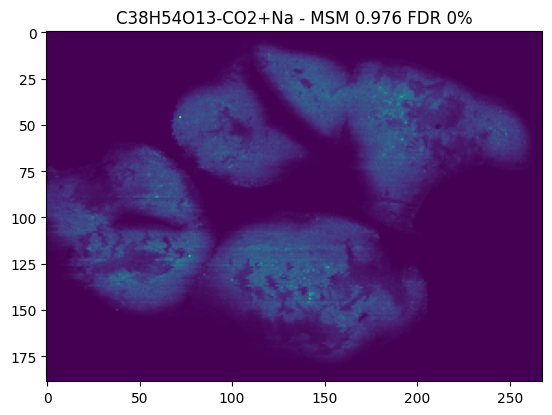

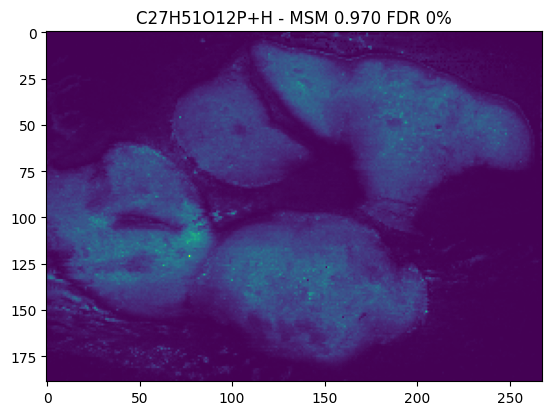

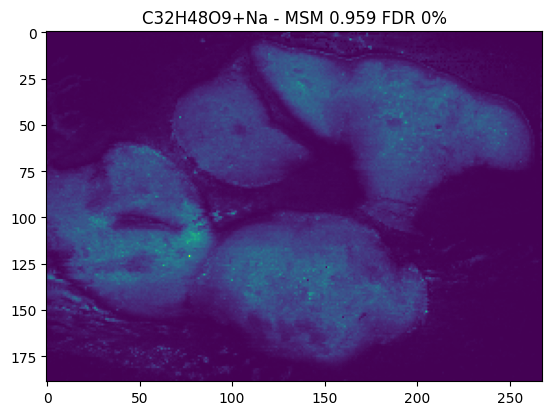

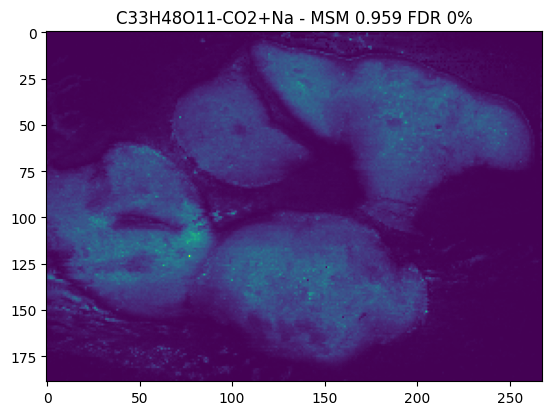

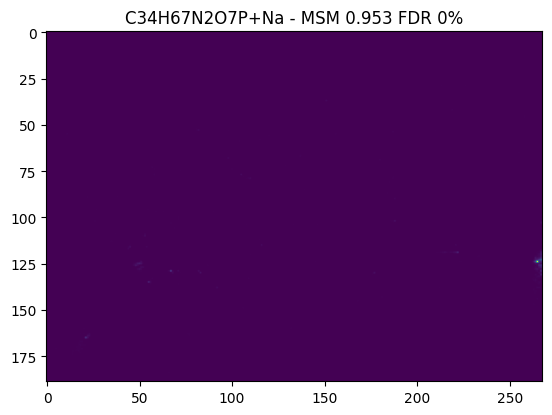

In [23]:
# Display most annotated molecules images
import matplotlib.pyplot as plt
for i, (formula_i, row) in enumerate(top_mols.head().iterrows()):
    plt.figure(i)
    plt.title(f'{row.mol}{row.modifier}{row.adduct} - MSM {row.msm:.3f} FDR {row.fdr*100:.0f}%')
    plt.imshow(formula_images[formula_i][0].toarray())

# <a name="clean"></a> 4. Clean Temp Data

In [24]:
pipeline.clean()

INFO:annotation-pipeline:Removed 2 objects from aws_s3://lithops-pipelines/metabolomics/cache/vm/db_config3/
INFO:annotation-pipeline:Removed 8 objects from aws_s3://lithops-pipelines/metabolomics/cache/vm/CT26_xenograft/
